In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Preprocessing

## Installation and import of the needed libraries


In [2]:
COLAB_ENV = (
    "google.colab" in str(get_ipython())
    if hasattr(__builtins__, "__IPYTHON__")
    else False
)
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")


Currently not running in a Colab environment


### Installation (mandatory on Colab)

First of all we clone the Github repository in order to have all the needed files to perform our analysis.

This is needed only if the current notebook isn't executed directly from the repository folder (e.g. Google Colab)


In [3]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import and configuration setup


In [4]:
# python modules
import configparser
import re

# 3rd party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import cross_val_score

# user modules
from utils import util_data, util_preprocess, util_plot, util_models

In order to manage the randomness we wrote the following cell to make the experiments reproducible, check the following [link](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness).

A numpy Random Generator object is constructed for controlling randomness: necessary for robust results in estimator performance with cross-validation.


In [5]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

Moreover we import the configuration file to have all the parameters along the notebook.


In [6]:
config = configparser.ConfigParser()
config.read("config.ini")

['config.ini']

In [14]:
ds_conf = config["GSMARENA_DS"]
# Download the training and test datasets
download_helper = util_data.DownloadHelper(
    ds_conf["url"], ds_conf["name"], ds_conf["mode"], quiet=False
)

download_helper.download()

File gsm.csv already exists. Skip download.


In [15]:
df_raw = download_helper.read_csv(low_memory=False, sep=",")

## Exploration of scraped data

For the project we use the following dataset from Kaggle: [dataset](https://www.kaggle.com/datasets/msainani/gsmarena-mobile-devices).

It gives information about different characteristics of the smartphones (e.g. RAM, cores, ...) and the target variable is the price range of the device. The list has been scraped from the known website [GSMArena](gsmarena.com).

After that we downloaded the dataset we can load it as a dataframe to leverage Pandas built-in functions.


### Preliminary exploration for preprocessing

The dataset has 10679 samples, each with 86 features. However, only some of the features are necessary for the task, so we can remove the others.

All the columns are text data.

In [16]:
df_raw.head(3)

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,main_camera_dual_or_triple,battery_music_play,selfie_camera_triple,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by
0,Benefon,Vega,GSM,GSM 900,No,No,1999,Discontinued,145 x 56 x 23 mm (5.71 x 2.20 x 0.91 in),190 g (6.70 oz),...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,4 - 10 h,3 - 6 days
1,Garmin-Asus,nuvifone M10,GSM / HSPA,GSM 900 / 1800 / 1900,NaN,NaN,"2010, January. Released 2010, March",Discontinued,-,-,...,NaN,NaN,NaN,NaN,V2,NaN,NaN,GSM 850 / 1800 / 1900 - US version,Up to 8 h,Up to 600 h (2G) / Up to 600 h (3G)
2,Gigabyte,GSmart G1305 Boston,GSM / HSPA,GSM 850 / 900 / 1800 / 1900,NaN,NaN,"2010, April. Released 2010, April",Discontinued,116 x 56.8 x 12.4 mm (4.57 x 2.24 x 0.49 in),118 g (4.16 oz),...,NaN,NaN,NaN,NaN,V2,NaN,NaN,NaN,Up to 7 h 10 min,Up to 410 h


In [17]:
print(f"Number of rows: {df_raw.shape[0]}")
print(f"Number of columns: {df_raw.shape[1]}")

Number of rows: 10668
Number of columns: 86


In [18]:
print(df_raw.columns)

Index(['oem', 'model', 'network_technology', 'network_2g_bands',
       'network_gprs', 'network_edge', 'launch_announced', 'launch_status',
       'body_dimensions', 'body_weight', 'body_sim', 'display_type',
       'display_size', 'display_resolution', 'display', 'memory_card_slot',
       'memory_phonebook', 'memory_call_records', 'sound_loudspeaker',
       'sound_alert_types', 'sound_3.5mm_jack', 'comms_wlan',
       'comms_bluetooth', 'comms_gps', 'comms_radio', 'comms_usb',
       'features_sensors', 'features_messaging', 'features_browser',
       'features_clock', 'features_alarm', 'features_games', 'features_java',
       'features', 'misc_colors', 'network_3g_bands', 'network_speed',
       'platform_os', 'platform_chipset', 'platform_cpu', 'platform_gpu',
       'memory_internal', 'main_camera_single', 'main_camera_video',
       'misc_price', 'main_camera_features', 'body', 'network_4g_bands',
       'body_build', 'display_protection', 'memory', 'main_camera_dual',
       

In [19]:
df_raw.dtypes.value_counts()

object    86
dtype: int64

### Explore relevant features

- _misc_price_: label for the classification
- _launch_announced_: year of the announcement
- _network_technology_: 3G, 4G, 5G
- **Float features**: display_size, battery
- **Binary features**: display_type, memory_card_slot, sound_loudspeaker, sound_3.5mm_jack, comms_wlan, comms_nfc, battery_charging, body
- **Multi column features**: display_resolution, memory_internal
- **Camera features**: main_camera, selfie_camera


In [20]:
df_copy = df_raw.copy()

#### Explore the launch_announced column

There are 91 values which are NaN. However, these samples belongs to two distinct categories:

- 82 samples don't have any price, so without a proper label they must be dropped.
- 9 samples have a price, but carefully looking at the "launch_status", only two of them have been "discontinued", while the remaining ones have been "cancelled".

Nonetheless, these 91 samples can be easily dropped, because only for 2 of them the launch year could be found, but a quick online search doesn't provide any results.

In [24]:
def extract_year(df: pd.DataFrame, feat_col: str, only_na=True):
    # pattern to extract year
    pat_year = r"([\d]{4})"
    # year series
    ser_year = df_copy[feat_col]
    
    ser_year = util_preprocess.DataTransformer.process_float_feature(ser_year, pat_year)
    if only_na:
        return df.loc[ser_year.isna()]
    return df.loc[ser_year.notna()]

In [60]:
cols = ["oem", "model", "launch_announced", "launch_status", "misc_price"]
df_year_na = extract_year(df_copy, "launch_announced").dropna(subset="misc_price")
df_year_na[cols]

,oem,model,launch_announced,launch_status,misc_price
853,Xiaomi,Mi Max 4,Not announced yet,Cancelled,About 300 EUR
854,Xiaomi,Mi Max 4 Pro,Not announced yet,Cancelled,About 350 EUR
1642,Coolpad,3632,Not announced yet,Cancelled,About 100 EUR
2610,Asus,Z801,V1,Discontinued,About 260 EUR
4915,Lenovo,ideapad,V1,Cancelled,About 130 EUR
5584,Meizu,PRO 5 mini,Not announced yet,Cancelled,About 360 EUR
8975,Samsung,Galaxy On5 (2016),Not announced yet,Cancelled,About 220 EUR
10059,Vodafone,830i,V1,Discontinued,About 170 EUR
10233,Xiaomi,Redmi Pro 2,Not announced yet,Cancelled,About 210 EUR


#### Explore the misc_price column

There are only 6537 valid price rows. For most of the models the currency available is EURO, but for the others a suitable conversion rate should be found to estimate the actual price in EURO. This could be difficult due to different [purchasing power parities](https://data.oecd.org/conversion/purchasing-power-parities-ppp.htm) and the region market (Europe, India, USA), but after some observations they are estimated as follows:

- INR -> EUR: a linear regression model is fitted on some of the available data to find the conversion rate. A comparison with the median rate and an [average rate retrieved online](https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-inr.en.html) shows that the one estimated is the most accurate.
- USD -> EUR: some prices are outliers, i.e. shows a conversion rate too much higher or smaller that a "real" rate (e.g. 0.40 or 2), for this reason even a linear regression isn't suitable because too much sensible to these values in the training dataset. The best result is achieved with the Huber regressor.
- GBP -> EUR: few samples are available to estimate the price, so the only way to compute the price in EURO is to use the [online rate](https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/eurofxref-graph-gbp.en.html).

In [178]:
misc_price = df_copy["misc_price"]
to_replace = {
    "<e2><80><89>": " ",
    "<e2><82><ac>": "EUR",
    "<e2><82><B9>": "INR",
    "<c2><a3>": "GBP",
    "€": "EUR",
    "\$": "USD",
    "£": "GBP",
    "\u2009": " ",
    "(,)(?=[\d]{3})": "",
}
for k, v in to_replace.items():
    misc_price = misc_price.str.replace(k, v, regex=True, flags=re.IGNORECASE)

print(f"Number of valid 'misc_price' rows: {misc_price.count()}")

Number of valid 'misc_price' rows: 6527


In [174]:
tmp = misc_price[misc_price.str.contains("INR", na=False)]
tmp_u = tmp[tmp.str.contains("USD", na=False)]
tmp_g = tmp[tmp.str.contains("GBP", na=False)]
tmp_e = tmp[tmp.str.contains("EUR", na=False)]
tmp_gu = tmp_g.index.union(tmp_u.index).difference(tmp_e.index)
print(f"Shape of USD: {tmp_u.shape}")
print(f"Shape of GBP: {tmp_g.shape}")
print(f"Shape of EUR: {tmp_e.shape}")
# misc_price.loc[tmp_gu]

Shape of USD: (60,)
Shape of GBP: (57,)
Shape of EUR: (40,)


Conversion rate between USD and EUR.


The presence of some outliers denotes that a linear regression model might not fit correctly some prices, because the training process could be drifted by "outlier" conversion rates.

It's better to estimate the prices with a regression less sensible to outliers, i.e. the Huber Regressor.

In [179]:
curr = "USD"
prices_ext, conversion_rate = util_preprocess.extract_prices_rate(curr, misc_price)

# add the year to the conversion rate
conv_rate_year = pd.concat(
    [conversion_rate, ser_year.loc[conversion_rate.index]], axis=1
).sort_values("conversion_rate")
print(f"Year coverage: {conv_rate_year['launch_announced'].unique()}")

Number of prices: 164
Year coverage: [2019. 2020. 2018.]


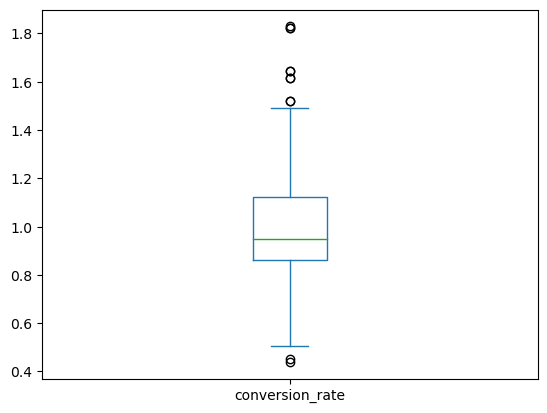

In [180]:
conversion_rate.plot.box(whis=1.5)
plt.show()

In [181]:
df_concat = pd.concat([conversion_rate, prices_ext.loc[conversion_rate.index]], axis=1)
util_data.compute_outlier(df_concat, "conversion_rate").sort_values(by="conversion_rate")

Lower bound: 0.47
Upper bound: 1.52
Number of outliers: 11


,conversion_rate,eur,usd
1493,0.437331,997.14,436.08
1567,0.452106,1172.27,529.99
1278,1.518330,92.20,139.99
395,1.518330,92.20,139.99
426,1.615594,587.40,949.00
1309,1.615594,587.40,949.00
1311,1.643097,419.33,689.00
428,1.643097,419.33,689.00
447,1.821494,279.99,510.00
1330,1.821494,279.99,510.00


In [182]:
from sklearn.model_selection import RandomizedSearchCV

X, y = prices_ext["eur"].values.reshape(-1, 1), prices_ext[curr.lower()].values

params = {
    "epsilon": np.linspace(1, 2, num=10),
    "max_iter": [100],
    "alpha": np.linspace(0.0001, 0.1, num=20),
    "fit_intercept": [False],
    "tol": np.linspace(1e-5, 1e-4, num=10)
}
scoring = ["neg_root_mean_squared_error", "r2"]
rscv = RandomizedSearchCV(HuberRegressor(), params, n_iter=20, scoring=scoring, n_jobs=-1,
                          refit="r2", cv=5, verbose=2, error_score=np.nan)
rscv.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\andre\miniconda3\envs\master-aiii\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\andre\miniconda3\envs\master-aiii\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\andre\miniconda3\envs\master-aiii\lib\site-packages\sklearn\linear_model\_huber.py", line 338, in fit
    raise ValueError(
ValueError: HuberRegressor convergence failed: l-BFGS-b solver terminated with ABNORMAL_TERMINATION_IN_LNSRCH

  warnings.warn(some_fi

RandomizedSearchCV(cv=5, estimator=HuberRegressor(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': array([0.0001    , 0.00535789, 0.01061579, 0.01587368, 0.02113158,
       0.02638947, 0.03164737, 0.03690526, 0.04216316, 0.04742105,
       0.05267895, 0.05793684, 0.06319474, 0.06845263, 0.07371053,
       0.07896842, 0.08422632, 0.08948421, 0.09474211, 0.1       ]),
                                        'epsilon': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ]),
                                        'fit_intercept': [False],
                                        'max_iter': [100],
                                        'tol': array([1.e-05, 2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05,
       9.e-05, 1.e-04])},
                   refit='r2', scoring=['neg_root_mean_squared_error', 'r2'],
                   verbose=2)

In [183]:
pd.DataFrame(rscv.cv_results_).sort_values(by="std_test_r2").iloc[0]

mean_fit_time                                                                       0.019202
std_fit_time                                                                        0.003191
mean_score_time                                                                     0.001796
std_score_time                                                                      0.000397
param_tol                                                                            0.00004
param_max_iter                                                                           100
param_fit_intercept                                                                    False
param_epsilon                                                                       1.666667
param_alpha                                                                         0.015874
params                                     {'tol': 4e-05, 'max_iter': 100, 'fit_intercept...
split0_test_neg_root_mean_squared_error                               

In [194]:
X, y = prices_ext["eur"].values.reshape(-1, 1), prices_ext[curr.lower()].values

model_median = util_models.FixedLinearRegressor(
    conversion_rate.median(), fit_intercept=False
)
model_fit = HuberRegressor(fit_intercept=False, tol=0.00004, alpha=0.015, epsilon=1.67)
model_rate = util_models.FixedLinearRegressor(1.14 - 0.22, fit_intercept=False)

models = [model_median, model_fit, model_rate]
names = ["median", "linear regressor", "online_rate"]
X_test, y_test, y_preds = util_models.compare_models(X, y, models, names, rng=rng)

median coefficients: [0.94851752]
median RMSE: 112.84
median r2-score: 0.78
median MAE: 62.66

linear regressor coefficients: [0.92678468]
linear regressor RMSE: 112.54
linear regressor r2-score: 0.78
linear regressor MAE: 62.26

online_rate coefficients: [0.92]
online_rate RMSE: 112.61
online_rate r2-score: 0.78
online_rate MAE: 62.40



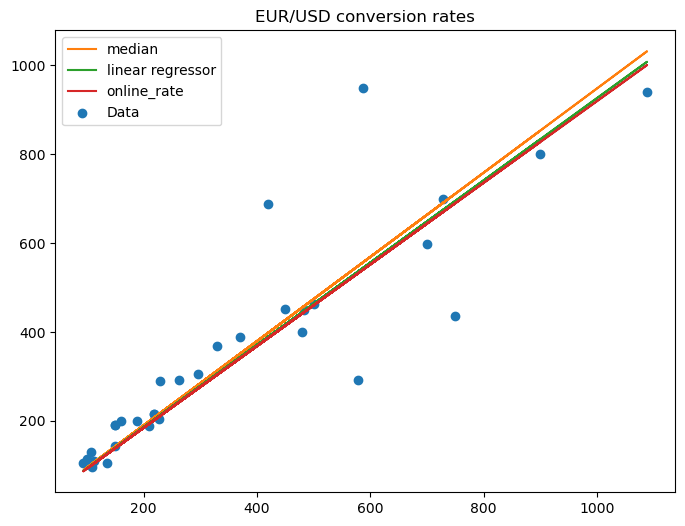

In [195]:
# plot the data
util_plot.plot_compare_models(
    X_test, y_test, y_preds, names, f"EUR/{curr} conversion rates"
)

Conversion rate between GBP and EUR

The number of samples to retrieve the correct exchange rate is to low (# samples=3). For this reason we decided to use the one retrieved online, which is more accurate, that is 0.89

In [198]:
curr = "GBP"
prices_ext, conversion_rate = util_preprocess.extract_prices_rate(curr, misc_price)

Number of prices: 3


Number of prices: 187
Year coverage: [2019. 2020. 2018.]


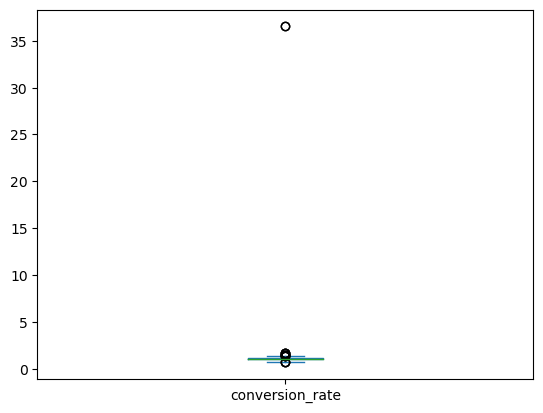

In [206]:
curr = "GBP"
prices_ext, conversion_rate = util_preprocess.extract_prices_rate(curr, misc_price)

# add the year to the conversion rate
conv_rate_year = pd.concat(
    [conversion_rate, ser_year.loc[conversion_rate.index]], axis=1
).sort_values("conversion_rate")
print(f"Year coverage: {conv_rate_year['launch_announced'].unique()}")

conversion_rate.plot.box(whis=1.5)
plt.show()

median coefficients: [1.07924074]
median RMSE: 97.97
median r2-score: 0.80
median MAE: 68.30

online_rate coefficients: [0.87]
online_rate RMSE: 72.22
online_rate r2-score: 0.89
online_rate MAE: 40.54



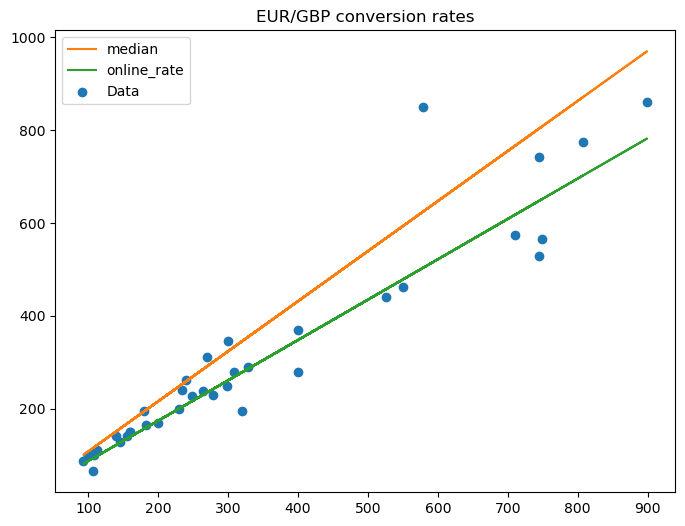

In [201]:
X, y = prices_ext["eur"].values.reshape(-1, 1), prices_ext[curr.lower()].values

model_median = util_models.FixedLinearRegressor(
    conversion_rate.median(), fit_intercept=False
)
model_rate = util_models.FixedLinearRegressor(0.87, fit_intercept=False)

models = [model_median, model_rate]
names = ["median", "online_rate"]
X_test, y_test, y_preds = util_models.compare_models(X, y, models, names, rng=rng)

# plot the data
util_plot.plot_compare_models(
    X_test, y_test, y_preds, names, f"EUR/{curr} conversion rates"
)

Conversion rate between INR and EUR

In [62]:
curr = "INR"
prices_ext, conversion_rate = util_preprocess.extract_prices_rate(curr, misc_price)

# add the year to the conversion rate
conv_rate_year = pd.concat(
    [conversion_rate, ser_year.loc[conversion_rate.index]], axis=1
).sort_values("conversion_rate")
print(f"Year coverage: {conv_rate_year['launch_announced'].unique()}")

Number of prices: 40
Year coverage: [2020. 2019.]


In [63]:
print(conversion_rate.describe())

count     40.000000
mean      86.192011
std       13.368410
min       59.136201
25%       75.602269
50%       87.047122
75%       96.436554
max      110.067915
Name: conversion_rate, dtype: float64


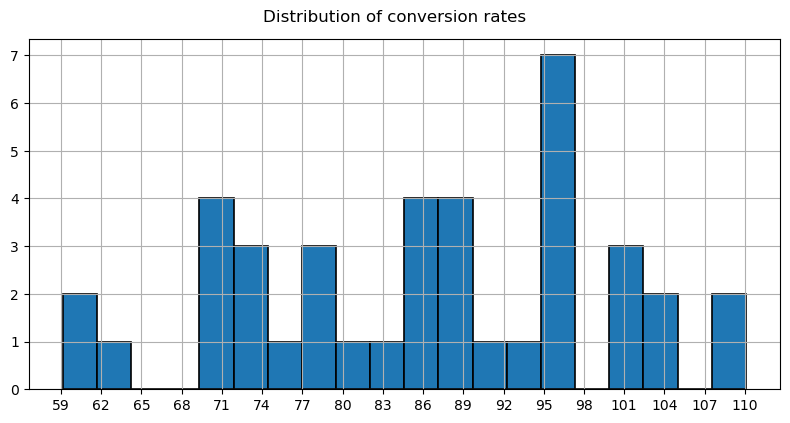

In [66]:
util_plot.plot_series_distribution(conversion_rate, "Conversion rate distribution")

A small standard deviation for the estimator and the absence of outliers denotes that the price pairs can be correctly estimated by a linear regressor.

In [37]:
_, bins = np.histogram(conversion_rate, bins="doane")

In [58]:
X, y = prices_ext["eur"].values.reshape(-1, 1), prices_ext[curr.lower()].values
idx = rng.permutation(X.shape[0])
X, y = X[idx], y[idx]

model_fit = LinearRegression(fit_intercept=False)

scores = -cross_val_score(model_fit, X, y, cv=5, scoring="neg_mean_absolute_error")
pd.Series(scores).describe()

count       5.000000
mean     4800.251960
std      2893.992371
min      1594.641510
25%      3282.819489
50%      4679.948133
75%      5079.642571
max      9364.208094
dtype: float64

median coefficients: [87.04712214]
median RMSE: 4220.15
median r2-score: 0.93
median MAE: 3555.36

linear regressor coefficients: [91.2907155]
linear regressor RMSE: 4881.77
linear regressor r2-score: 0.90
linear regressor MAE: 3743.25

online_rate coefficients: [81.749]
online_rate RMSE: 4041.50
online_rate r2-score: 0.93
online_rate MAE: 3512.91



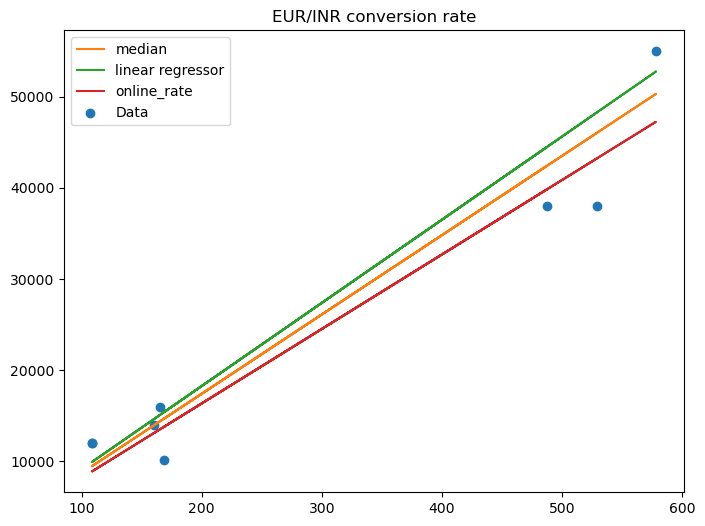

In [52]:
X, y = prices_ext["eur"].values.reshape(-1, 1), prices_ext[curr.lower()].values

model_median = util_models.FixedLinearRegressor(
    conversion_rate.median(), fit_intercept=False
)
model_linear = LinearRegression(fit_intercept=False)
model_rate = util_models.FixedLinearRegressor(81.749, fit_intercept=False)

models = [model_median, model_linear, model_rate]
names = ["median", "linear regressor", "online_rate"]
X_test, y_test, y_preds = util_models.compare_models(X, y, models, names, rng=rng)

# plot the data
util_plot.plot_compare_models(
    X_test, y_test, y_preds, names, f"EUR/{curr} conversion rate"
)

#### Float features: display_size and battery

- display_size: contains the display in inches.
- battery: contains the battery capacity in mAh.


In [ ]:
df_copy.loc[0:5, ["display_size", "battery"]]


,display_size,battery
0,NaN,Removable Li-Ion battery
1,"3.5 inches, 34.9 cm",Removable Li-Ion 1500 mAh battery
2,"3.2 inches, 30.5 cm (~46.3% screen-to-body ratio)",Removable Li-Po 1230 mAh battery
3,"2.8 inches, 24.3 cm (~43.7% screen-to-body ratio)",Removable Li-Ion 1500 mAh battery
4,"6.3 inches, 98.0 cm (~81.3% screen-to-body ratio)",Non-removable Li-Po 3700 mAh battery
5,"5.7 inches, 80.7 cm (~79.8% screen-to-body ratio)",Non-removable Li-Po 2800 mAh battery


#### Binary features

- display_type: extract whether the display is OLED or LCD
- memory_card_slot: the device contains a slot for a microSD is contained
- sound_loudspeaker: the speaker is stereo or mono
- sound_3.5mm_jack: the device has a 3.5mm jack
- comms_wlan: the technology of the wlan chipset, i.e. 2.4GHz or 5Ghz
- comms_nfc: the device supports the nfc
- battery_charging: extract whether the device has support for fast-charging
- body: extract whether the device is waterproof

For some of these features (display_type, comms_wlan, battery_charging, body) each feature is changed from the original one to extract more relevant information about the devices.


The "display_type" feature contains the keyword OLED, which depicts different display device technology, such as P-OLED, AMOLED or Super Retina. Otherwise the feature corresponds to a LCD display technology.


In [ ]:
df_copy.loc[0:5, ["display_type"]]


,display_type
0,Monochrome graphic
1,"TFT resistive touchscreen, 65K colors"
2,"TFT capacitive touchscreen, 256K colors"
3,"TFT capacitive touchscreen, 256K colors"
4,"P-OLED capacitive touchscreen, 16M colors"
5,"P-OLED capacitive touchscreen, 16M colors"


The "comms_wlan" feature contains the different [IEEE 802.11 standard](https://en.wikipedia.org/wiki/IEEE_802.11) supported. To distinguish whether the device supports the 5GHz or only the 2.4GHz depends on the standard adopted: the former is supported if at least one of "a" or "ac" generations is present in the feature.


In [ ]:
df_copy.loc[0:5, ["comms_wlan"]]


,comms_wlan
0,No
1,Wi-Fi 802.11b/g
2,Wi-Fi 802.11 b/g
3,Wi-Fi 802.11 b/g
4,"Wi-Fi 802.11 a/b/g/n/ac, dual-band, Wi-Fi Direct, DLNA, hotspot"
5,"Wi-Fi 802.11 a/b/g/n/ac, dual-band, Wi-Fi Direct, DLNA, hotspot"


When the "battery_charging" feature contains the keyword wireless the device supports any type of wireless charging (QI, Power Delivery), otherwise only a wired charging is possible.


In [ ]:
df_copy.loc[0:5, ["battery_charging"]]


,battery_charging
0,<NA>
1,<NA>
2,<NA>
3,<NA>
4,Fast charging 18W USB Power Delivery 2.0 QI wireless charging
5,Fast charging 18W USB Power Delivery 2.0 QI wireless charging


The "body" feature might contain the keywords "IP6x", "splash" or "water" when the device is waterproof, a characteristic important for expensive devices.


In [ ]:
df_copy.loc[0:5, ["body"]]


,body
0,<NA>
1,<NA>
2,<NA>
3,Trackball
4,IP68 dust/water resistant (up to 1.5m for 30 mins)
5,IP68 dust/water resistant (up to 1.5m for 30 mins)


The remaining binary features usually contains the word "Yes" to describe the presence of the feature or in some case they explictly mention the feature.


In [ ]:
df_copy.loc[
    0:5, ["memory_card_slot", "sound_loudspeaker", "sound_3.5mm_jack", "comms_nfc"]
]


,memory_card_slot,sound_loudspeaker,sound_3.5mm_jack,comms_nfc
0,No,No,No,<NA>
1,microSDHC (dedicated slot),Yes,Yes,<NA>
2,microSDHC (dedicated slot),Yes,Yes,<NA>
3,microSDHC (dedicated slot),Yes,Yes,<NA>
4,No,"Yes, with stereo speakers",No,Yes
5,No,"Yes, with stereo speakers",No,Yes


#### Multi column features: display_resolution and memory_internal

- display_resolution: contains the resolution of the display in pixels, both for the width and the height. If at least one of the two values is smaller than 1000, then the value is dropped because it's too small to be a smartphone display. Pheraps it could be a smartwatch display or an old smartphone.
- memory_internal: contains the internal memory of the device in GB, both for the RAM and the ROM. When the device has at least one capacity expressed in MB, then the value is dropped because it's too small to be relevant.


In [ ]:
df_copy.loc[0:5, ["display_resolution", "memory_internal"]]


,display_resolution,memory_internal
0,6 lines,<NA>
1,"480 x 800 pixels, 5:3 ratio (~267 ppi density)",4GB 512MB RAM
2,"320 x 480 pixels, 3:2 ratio (~180 ppi density)",256MB RAM
3,"240 x 320 pixels, 4:3 ratio (~143 ppi density)","256MB RAM, 512MB"
4,"1440 x 3040 pixels, 19:9 ratio (~537 ppi density)","64GB 6GB RAM, 128GB 6GB RAM"
5,"1080 x 2280 pixels, 19:9 ratio (~444 ppi density)","64GB 6GB RAM, 128GB 6GB RAM"


#### Network technology

The "network_technology" feature contains the different network technologies supported by the device. The most important ones are:

- 5G: the device supports the 5G network
- 4G: the device supports the 4G network, usually described as LTE.
- 3G: the device supports the 3G network, usually described as UMTS or HSPA.

The other technologies are less important, such as GSM, CDMA, EVDO or even devices with no network support are dropped.


In [ ]:
df_copy.loc[0:5, "network_technology"]


0                               GSM
1                        GSM / HSPA
2                        GSM / HSPA
3                        GSM / HSPA
4    GSM / CDMA / HSPA / EVDO / LTE
5    GSM / CDMA / HSPA / EVDO / LTE
Name: network_technology, dtype: string

#### Camera features: main_camera and selfie_camera

Each feature is split into different columns, each one describing a different setup of the camera in the device. The columns are named as "main_camera_single", "main_camera_dual", etc. The number of columns is variable, depending on the number of cameras present in the device.

Only one column for both "main" and "selfie" camera is filled (e.g. "main_camera_single" and "selfie_camera_dual" are filled), while the other columns are filled with NaN values. In this way the resolution of only the principal camera is considered, while the other ones are ignored. In addition, the number of cameras is extracted both for the main and the selfie cameras.


In [ ]:
df_copy.loc[
    0:5,
    [
        "main_camera_single",
        "main_camera_dual",
        "main_camera_quad",
        "main_camera_triple",
        "main_camera_five",
        "main_camera_dual_or_triple",
    ],
]


,main_camera_single,main_camera_dual,main_camera_quad,main_camera_triple,main_camera_five,main_camera_dual_or_triple
0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,"5 MP, AF",<NA>,<NA>,<NA>,<NA>,<NA>
2,"5 MP, AF",<NA>,<NA>,<NA>,<NA>,<NA>
3,"2 MP, AF",<NA>,<NA>,<NA>,<NA>,<NA>
4,<NA>,"12.2 MP, f/1.7, 27mm (wide), 1/2.55"", 1.4<c2><b5>m, dual pixel PDAF, OIS 16 MP, f/2.4, 50mm (telephoto), 1/3.6"", 1.0<c2><b5>m, PDAF, OIS, 2x optical zoom",<NA>,<NA>,<NA>,<NA>
5,<NA>,"12.2 MP, f/1.7, 27mm (wide), 1/2.55"", 1.4<c2><b5>m, dual pixel PDAF, OIS 16 MP, f/2.4, 50mm (telephoto), 1/3.6"", 1.0<c2><b5>m, PDAF, OIS, 2x optical zoom",<NA>,<NA>,<NA>,<NA>


In [ ]:
df_copy.loc[0:5, ["selfie_camera_single", "selfie_camera_dual", "selfie_camera_triple"]]


,selfie_camera_single,selfie_camera_dual,selfie_camera_triple
0,<NA>,<NA>,<NA>
1,<NA>,<NA>,<NA>
2,<NA>,<NA>,<NA>
3,<NA>,<NA>,<NA>
4,<NA>,"8 MP, f/2.0, 22mm (wide), 1.22<c2><b5>m, no AF TOF 3D, (depth/biometrics sensor)",<NA>
5,<NA>,"8 MP, f/2.0, 22mm (wide), 1.22<c2><b5>m, no AF TOF 3D, (depth/biometrics sensor)",<NA>


## Preprocessing

We preprocess the data in order to make it suitable for the task. The preprocessing steps are the following:

- Drop the columns which are not relevant for the task.
- Process each feature in order to make it suitable for the task, as described in the previous section. If the preprocessing results in a NaN value in the feature, then the sample is dropped.
- For some feature, such as binary features, the NaN values are replaced to depict the absence of the feature. The other features are dropped if they contain NaN values because the value cannot be estimated.

Meny samples are dropped, but mostly because they are old devices, which are not relevant for the task, for example if the display resolution is smaller than 1000 pixels or if the internal memory is smaller than 1GB.

The final dataset contains 2154 samples.


In [90]:
filter_condition = [
    ("launch_announced", lambda x: x >= 2014),
    ("display_size", lambda x: (x >= 4) & (x <= 7.5)),
    ("display_height", lambda x: x >= 512),
    ("display_width", lambda x: x >= 512),
    ("num_main_camera", lambda x: x <= 4),
    ("memory_rom_gb", lambda x: x <= 256),
    ("memory_ram_gb", lambda x: x <= 32),
    ("battery", lambda x: x>= 1000),
    ("misc_price", lambda x: x <= 2000),
]

The dataset is filtered to keep only the samples which satisfy the following conditions:

- display_size in (4, 7.5)
- display_height and display_width > 512

With these conditions the dataset is reduced but we can be sure that the samples are smartphones and recent.

In [91]:
preprocess = util_preprocess.GSMArenaPreprocess("gsmarena.json")
df = preprocess(df_raw, filter_condition, verbose=False)

print(f"The dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataframe has 2159 rows and 22 columns.


Instead of simply removing duplicates, we keep only one duplicated sample by considering the median price. This is done because the price is the target of the task and we want to avoid that the model is biased towards the most expensive device.

Other techniques for detecting duplicates are possible, such as clustering or PCA, but the median price is a simple and effective way to remove duplicates.


In [92]:
# Show duplicated rows
def get_dup_rows(df: pd.DataFrame, drop_cols):
    dup_cols = df.columns.drop(drop_cols).to_list()
    dup_rows = df[df.duplicated(subset=dup_cols, keep=False)].copy()
    return dup_rows, dup_rows.groupby(dup_cols)


df_duplicates, df_groups = get_dup_rows(df, ["misc_price", "launch_announced", "oem_model"])

print(f"The dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"Number of duplicated rows: {df_groups.ngroups}")

# remove dupliates rows which are then substitued
df = df.drop(df_duplicates.index).reset_index(drop=True)
print(f"The dataframe after removing duplicates has {df.shape[0]} rows")

# add duplicated rows by joining the rows and replacing with the median price
for key, item in df_groups:
    el = item.iloc[0, :].copy()
    el.misc_price = item.misc_price.median()
    el.launch_announced = item.launch_announced.median()

    # define the oem and model
    oem_model = item.oem_model.unique()
    if len(oem_model) > 1:
        oem_model = " - ".join(oem_model)
    else:
        oem = oem[0]

    el.oem_model = oem_model
    
    df = pd.concat([df, el.to_frame().T], axis=0)

df = df.reset_index(drop=True)
print(f"The dataframe after adding duplicates has {df.shape[0]} rows")


The dataframe has 2159 rows and 22 columns.
Number of duplicated rows: 182
The dataframe after removing duplicates has 1729 rows
The dataframe after adding duplicates has 1911 rows


In [93]:
# save the dataframe
df.to_csv("data/processed/gsm.csv", index=True)